In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import torch
import matplotlib.pyplot as plt
import galsim
import numpy as np
import numpy.ma as ma

from case_studies.dc2_cataloging.utils.footprint import FootPrint
from bliss.catalog import TileCatalog

bands = ("u", "g", "r", "i", "z")

In [3]:
simulated_dataset_path = Path("/data/scratch/pduan/simulated_dataset")
simulated_data = []
for filename in os.listdir(simulated_dataset_path):
    if filename.endswith(".pt"):
        with open(simulated_dataset_path / filename, "rb") as f:
            simulated_data.append(torch.load(f))

In [4]:
simulated_data[0][0]["images"].shape

torch.Size([5, 2048, 2048])

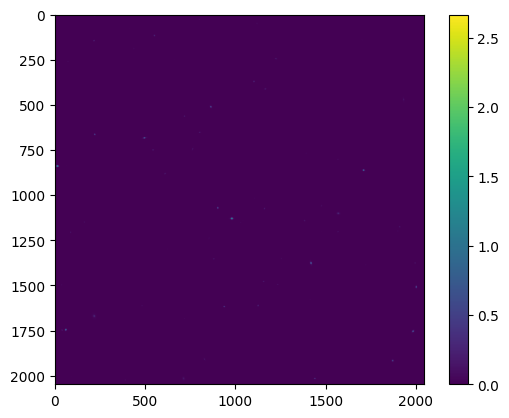

In [5]:
plt.imshow(simulated_data[0][0]["images"].norm(dim=0))
plt.colorbar()
plt.show()

In [6]:
footprint_slen = 100
footprints = FootPrint.get_footprints(simulated_data[0][0]["images"],
                                    TileCatalog({k: v.unsqueeze(0) 
                                                for k, v in simulated_data[0][0]["tile_catalog"].items()}),
                                    tile_slen=4, footprint_slen=footprint_slen)

In [7]:
len(footprints)

51

In [8]:
def check_footprints(footprints):
    for footprint in footprints:
        assert footprint.image.shape[1] == footprint_slen
        assert footprint.image.shape[2] == footprint_slen
        for k, v in footprint.params_dict.items():
            assert len(v.shape) == 1

In [9]:
check_footprints(footprints)

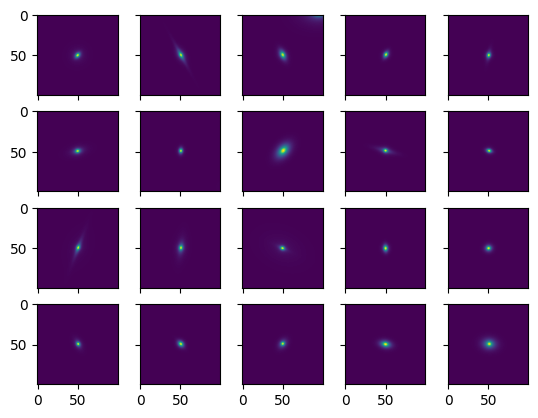

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=True)
for i in range(20):
    ax = axes[i // 5, i % 5]
    ax.imshow(footprints[i].image.norm(dim=0))
fig.show()

In [11]:
all_footprints = []
for batch in simulated_data:
    for datum in batch:
        footprints = FootPrint.get_footprints(datum["images"],
                                    TileCatalog({k: v.unsqueeze(0) 
                                                for k, v in datum["tile_catalog"].items()}),
                                    tile_slen=4, footprint_slen=footprint_slen)
        check_footprints(footprints)
        all_footprints.extend(footprints)

In [12]:
len(all_footprints)

16057

In [13]:
footprints_ellipticity = torch.stack([footprint.params_dict["ellipticity"] for footprint in all_footprints])

In [14]:
footprints_ellipticity.shape

torch.Size([16057, 2])

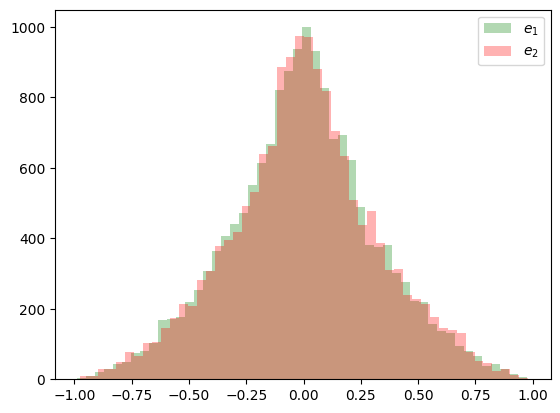

In [15]:
plt.hist(footprints_ellipticity[:, 0], alpha=0.3, color="green", bins=50,
         label="$e_1$")
plt.hist(footprints_ellipticity[:, 1], alpha=0.3, color="red", bins=50,
         label="$e_2$")
plt.legend()
plt.show()

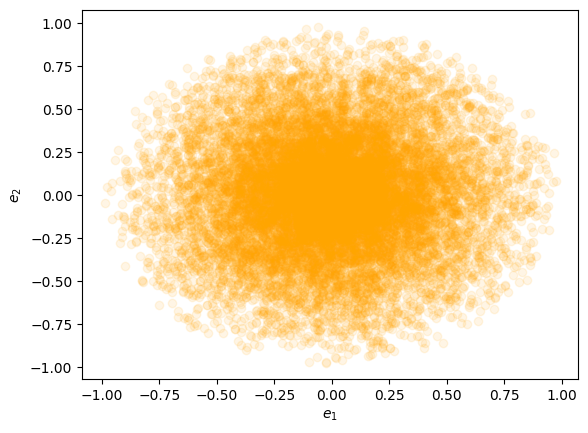

In [16]:
plt.scatter(footprints_ellipticity[:, 0],
            footprints_ellipticity[:, 1],
            color="orange", alpha=0.1)
plt.xlabel("$e_1$")
plt.ylabel("$e_2$")
plt.show()

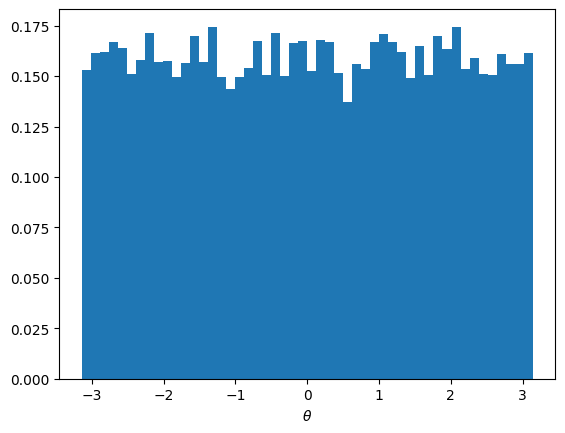

In [17]:
plt.hist(torch.arctan2(footprints_ellipticity[:, 1],
                       footprints_ellipticity[:, 0]), bins=50, density=True)
plt.xlabel(r"$\theta$")
plt.show()

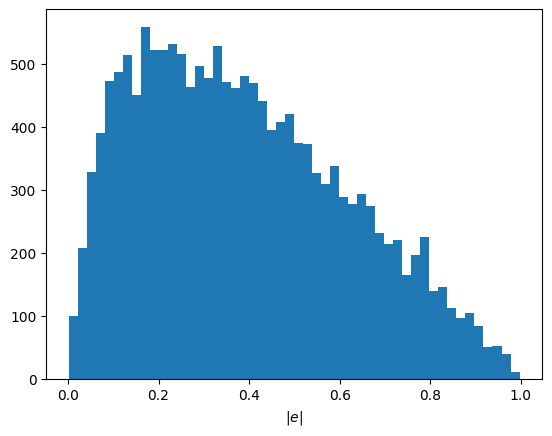

In [18]:
plt.hist(footprints_ellipticity.norm(dim=-1), bins=50)
plt.xlabel("$|e|$")
plt.show()

In [19]:
estimated_ellipticity = {band: [] for band in bands}
for footprint in all_footprints:
    for band_i, band in enumerate(bands):
        try:
            image = galsim.ImageF(footprint.image[band_i].numpy())
            moments = image.FindAdaptiveMom()
        except galsim.hsm.GalSimHSMError:
            estimated_ellipticity[band].append(torch.full((2, ), torch.nan))
            continue
        e1 = moments.observed_shape.e1
        e2 = moments.observed_shape.e2
        estimated_ellipticity[band].append(torch.tensor([e1, e2]))
estimated_ellipticity = {k: torch.stack(v) for k, v in estimated_ellipticity.items()}

In [20]:
for band, band_e in estimated_ellipticity.items():
    print(f"band {band} has {torch.isnan(band_e).sum().item()} nans")

band u has 60 nans
band g has 62 nans
band r has 58 nans
band i has 58 nans
band z has 62 nans


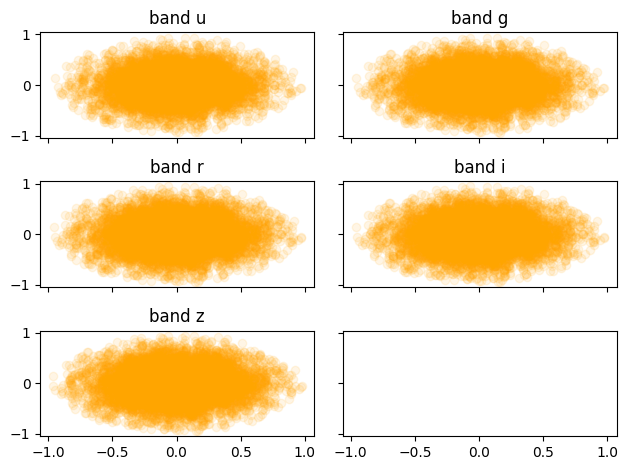

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
for band_i, band in enumerate(bands):
    ax = axes[band_i // 2, band_i % 2]
    ax.scatter(estimated_ellipticity[band][:, 0],
               estimated_ellipticity[band][:, 1],
               alpha=0.1,
               color="orange")
    ax.set_title(f"band {band}")
fig.tight_layout()
fig.show()

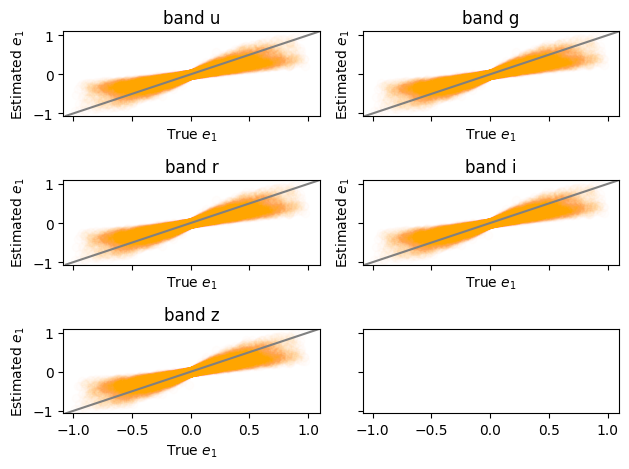

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
for band_i, band in enumerate(bands):
    ax = axes[band_i // 2, band_i % 2]
    ax.scatter(footprints_ellipticity[:, 0],
               estimated_ellipticity[band][:, 0],
               alpha=0.01,
               color="orange")
    ax.axline([0, 0], [1, 1], color="grey")
    ax.set_title(f"band {band}")
    ax.set_xlabel("True $e_1$")
    ax.set_ylabel("Estimated $e_1$")
fig.tight_layout()
fig.show()

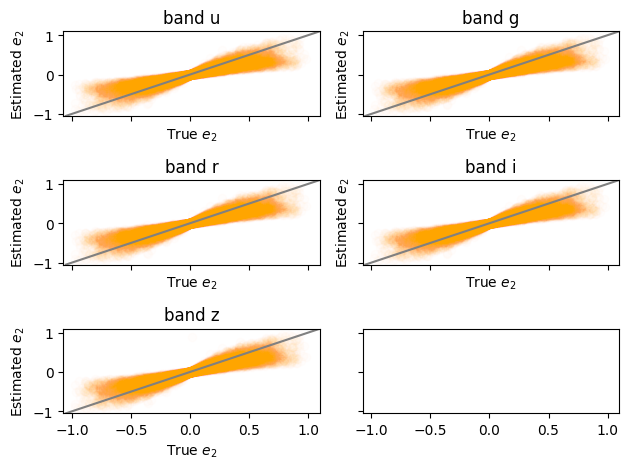

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
for band_i, band in enumerate(bands):
    ax = axes[band_i // 2, band_i % 2]
    ax.scatter(footprints_ellipticity[:, 1],
               estimated_ellipticity[band][:, 1],
               alpha=0.01,
               color="orange")
    ax.axline([0, 0], [1, 1], color="grey")
    ax.set_title(f"band {band}")
    ax.set_xlabel("True $e_2$")
    ax.set_ylabel("Estimated $e_2$")
fig.tight_layout()
fig.show()

In [24]:
for band_i, band in enumerate(bands):
    print(f"band {band} e_1 correlation:")
    print(np.array2string(ma.corrcoef(ma.masked_invalid(footprints_ellipticity[:, 0]),
                          ma.masked_invalid(estimated_ellipticity[band][:, 0])), precision=3))
    print(f"band {band} e_2 correlation:")
    print(np.array2string(ma.corrcoef(ma.masked_invalid(footprints_ellipticity[:, 1]),
                                      ma.masked_invalid(estimated_ellipticity[band][:, 1])), precision=3))

band u e_1 correlation:
[[1.    0.925]
 [0.925 1.   ]]
band u e_2 correlation:
[[1.    0.925]
 [0.925 1.   ]]
band g e_1 correlation:
[[1.    0.929]
 [0.929 1.   ]]
band g e_2 correlation:
[[1.    0.929]
 [0.929 1.   ]]
band r e_1 correlation:
[[1.    0.933]
 [0.933 1.   ]]
band r e_2 correlation:
[[1.    0.933]
 [0.933 1.   ]]
band i e_1 correlation:
[[1.    0.932]
 [0.932 1.   ]]
band i e_2 correlation:
[[1.    0.932]
 [0.932 1.   ]]
band z e_1 correlation:
[[1.    0.931]
 [0.931 1.   ]]
band z e_2 correlation:
[[1.    0.931]
 [0.931 1.   ]]
